I started with a simple CNN structure proposed by [comma.ai](https://github.com/commaai/research/blob/master/train_steering_model.py). It helped me develop an end to end pipeline quickly. The simple network did not perform very well as the car could not go past the first turn. I started with a simple cross validation strategy with a 80-20 split between training and validation set size. I mainly tuned the dropout parameter based on the validation performance but it did not improve the model performance by much.

I moved on to the [Nvidia model](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) because it is a more powerful network with proven success in real driving conditions. Since the paper only reported the overall structure of the network, I added nonlinear activation layers to learn more complex driving conditions and added dropout layers to control overfitting.

I have used data provided by Udacity only because collecting data without a joystick turned out to be extremely tedious with serious quaestion about the quality of the data generated.

I started out training the model with the center camera image only. This helped me troubleshoot and fine tune my pipeline quickly because I could run the model on a multi core CPU machine. In the next step I included the training data captured by the left and right cameras too. At this point using a GPU became a necessity rather than a choice. I added a steering bias, with the appropriate sign, to the data captured by the side cameras. This added more perspective to the view and the car could move further along the track.

The steering offset was a critical tuning parameter for the model. With offset values smaller than 0.25 the car stays in the middle of the lane and navigates well. However, it fails in the first sharp left turn. On the other hand, offset values larger than 3.0 can handle the sharp turns but the ride is very jittery and the car struggles to stay near the middle of the lane.

It was clear that the track has a bias towards left turns. In order to make sure the model generalizes well, every frame was flipped left to right based on a coin toss. Moreover, to let the model adapt to variable level of brightness of the track, the brightness level of the frames were randomly changed.

Data augmentation using random flip doubled the available data and random brightness change created a virtually infinite pool of data. From now on, I randomy picked 10000 samples from the pool in each epoch of training, out of which 8000 were used for actual training and the rest were used for cross validation. This strategy guaranteed that the model saw a well shuffled data at each epoch, essential to improve generalization of the model.

A lot of initial experiments with the model failed when the car failed to negotiate a sharp turn on the track. A common strategy could have been to record additional driving data capturing a recovery process so that the model learns what to do in that scenario. However, I conciously made a decision to not provide the model with this kind of assistance and let it learn from the available data itself. 

Each image in the training process was normalized to a range $(-1, 1)$, cropped 50 rows from the top and 20 rows from the bottom before feeding to the model. The cropping is a good way to filter out unnecesary information that the model does not need to learn and normalization is a great way to make sure that the backpropagated gradients are withing similar range. Here is an example of how the cropped image would look like.

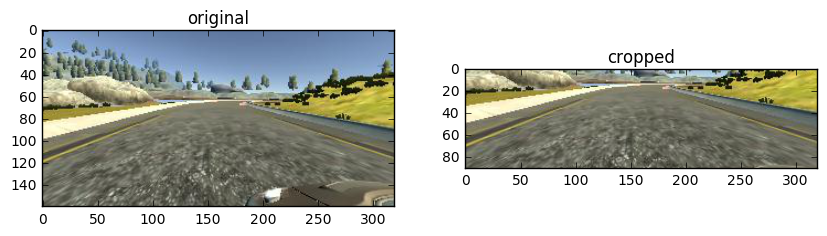

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 20])
im = mpimg.imread('Udacity_Data/data/IMG/left_2016_12_01_13_46_37_006.jpg')
y, x, c = im.shape
ax1.imshow(im)
ax1.set_title('original')

crop_im = im[50:y-20]
ax2.imshow(crop_im)
ax2.set_title('cropped')

Here are a few samples illustrating how images would appear following a random brightness change.

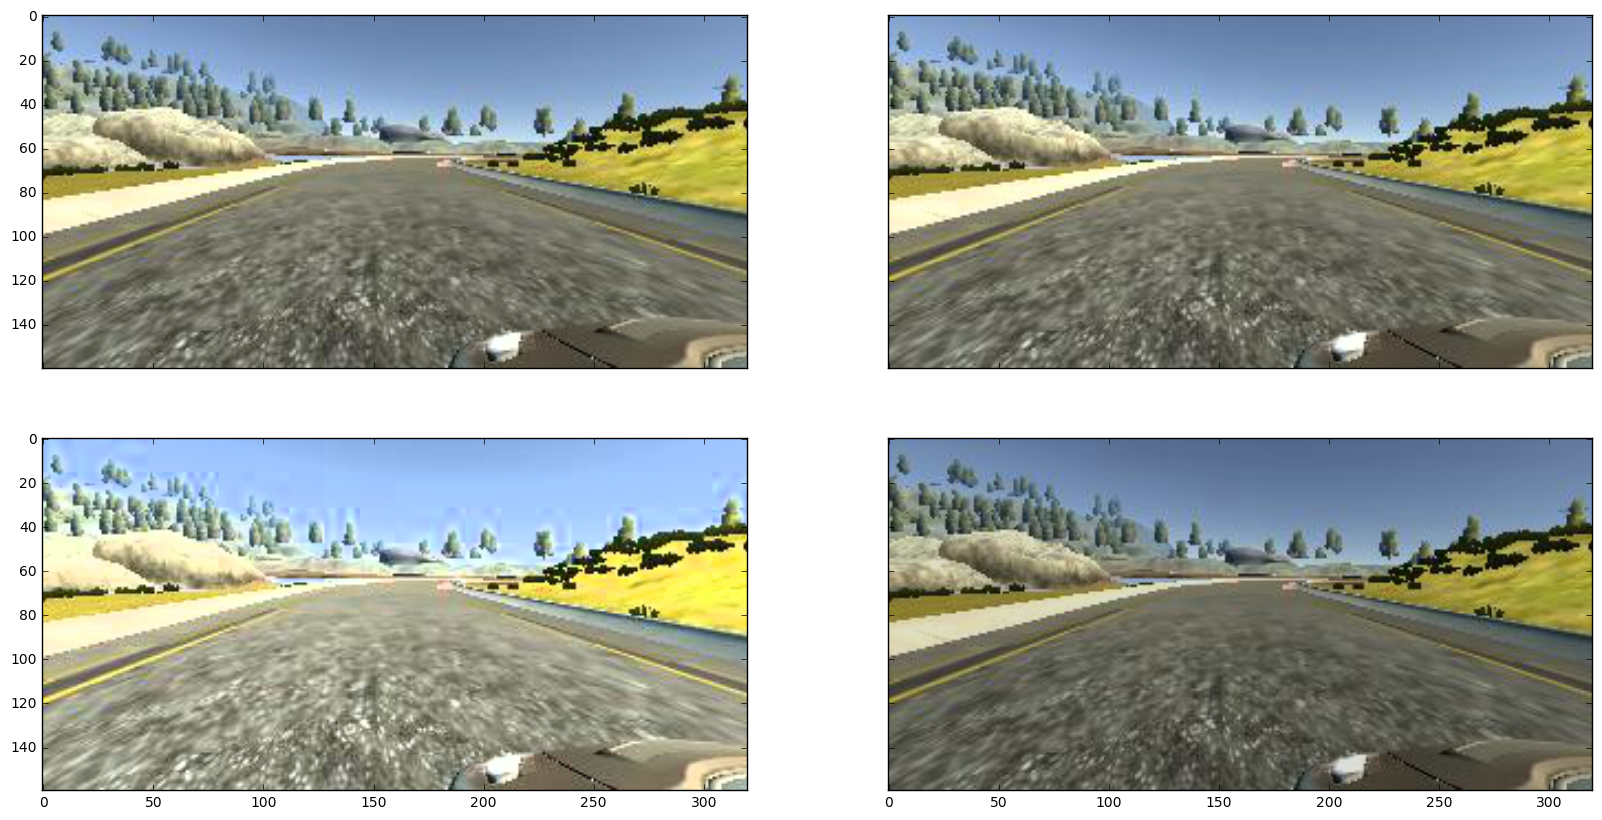

In [16]:
from model import augment_brightness_camera_images
import cv2

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=[20,10])
im = mpimg.imread('Udacity_Data/data/IMG/left_2016_12_01_13_46_37_006.jpg')

for i in range(2):
    for j in range(2):
        br_im = augment_brightness_camera_images(im)
        ax[i][j].imshow(br_im)

I did not want to modify the structure of the Nvidia network since it has a good track record. However, the paper did not discuss any detailed training strategies, I added the ELU activation because they can have negative values unlike in ReLUs and thereby speeding up learning. The next strategy to prevent overfitting, in addition to having a validation set, was to add a dropout layer after all three of the fully connected layers. 

The final network had the following structure:

* normalized cropped image
* 24 $(5 \times 5)$ conv layers
* elu
* 36 $(5 \times 5)$ conv layers
* elu
* 48 $(5 \times 5)$ conv layers
* elu
* 64 $(3 \times 3)$ conv layers
* elu
* 64 $(3 \times 3)$ conv layers
* elu
* flatten
* dense layer (100)
* dropout (0.5)
* elu
* dense layer (50)
* dropout (0.5)
* elu
* dense layer (10)
* dropout (0.5)
* elu
* dense layer (1)

A general observation was that the validation loss almost never reduced after 3 epochs. Not only that, more often than not, it started going up, sometimes significantly. Therefore, a manual early stopping strategy was adopted and I always trained for 3 epochs but saved the training model for reinitiate training, if required.

Based on the work shared through blogs and Udacity boards, I got a general idea about the value of the steering offset. Based on that, a search was performed to find the best steering offset between 0.15 and 0.40. The model was trained for three epochs for each value of the steering offset and the best model was saved. The figure below shows the performance comparison between training and validation sets for steering offset of $0.2$. It is clear that increasing the number of epochs is not going to improve the loss and justifies my choice of keeping the number of epochs to a maximum of 3.

I used the adam optimizer with the default learning rate value of 0.001 but added a decay rate of $10^{-6}$.

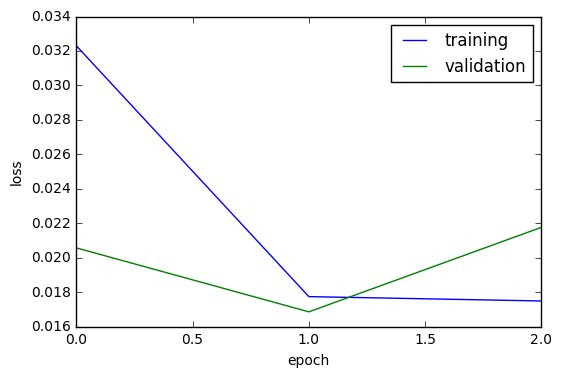

In [19]:
import _pickle as pickle

with open('history/nvidia_model_drop_0.5_steer_0.2.pkl', 'rb') as fid:
    l1, l2  = pickle.load(fid)
plt.plot(l1, label="training")
plt.plot(l2, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc=0)

The following figure shows the validation performance for all the offset values I tried.

history/nvidia_model_drop_0.5_steer_0.15.pkl
history/nvidia_model_drop_0.5_steer_0.2.pkl
history/nvidia_model_drop_0.5_steer_0.25.pkl
history/nvidia_model_drop_0.5_steer_0.3.pkl
history/nvidia_model_drop_0.5_steer_0.35.pkl
history/nvidia_model_drop_0.5_steer_0.4.pkl


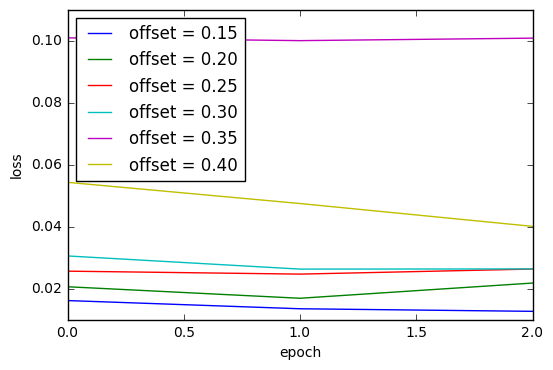

In [20]:
import glob
f = glob.glob('history/*.pkl')
for fi in f:
    print (fi)
    title = 'offset = %.2f' % float(fi.split('/')[-1].split('_')[-1][:-4])
    with open(fi, 'rb') as fid:
        l1, l2  = pickle.load(fid)
        plt.plot(l2, label=title)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc=2)

Judging by the performance of the validation set, I expected to pick the model with an offset value of $0.15$. Although the model did very well (smooth ride) on majority of the track, it failed to negotiate the sharp turn followed by the bridge. The models with offset values of $0.25$ and $0.3$, though produced a jerky ride, did complete the track successfully. The model with offset value of $0.35$ did poorly on the track, which may not be a surprise given the significantly large value of the loss.

Finally the model with the offset value of $0.4$ did very well on the track. This is the only model that actually drove the car like almost a human driver. It also drove the challenge track (without shadows) flawlessly. The only regions of the track where it adjusted the steering more than necessary were lanes with red and white stripes as border. This is interesting given the fact that most other (less powerful) models drove the car quite smoothly through that part. I am inclined to believe that some kind of bias in the training data might have to do with it.

One importnt lesson learnt from this exercise is that the performance on the validation set can only partially be associated with the success of the model. This is not surprising given the fact that majority of the tracks are quite straightforward to drive, with only a handful of locations where a sharp steering control is needed. The models that achieved lower loss compared to my best model actually did very well on the easier part of the track. However, this policy of cross validation served well to filter out the bad models because models with final validation loss values higher than 0.045 almost always performed poorly on the track.

It was a natural choice to try to train the model with more data to make the ride smoother. However, all attempts to do that resulted in a worse model.

The other tuning parameter that I considered critical to the performance was the dropout percentage. For the best steering offset search, I kept the dropout at 50% for all the three dropout layers. The only other value I tried was no dropout at all, which ended up in a bad model.

At this point I do not see a need to train the model further on the same track as that will almost certainly lead to overfitting. What gave me confidence was that the car drove without any problem on the simpler version of the challenge track (no shadows) although it was never trained on that track. However, the model failed with shadows turned on, which I consider to be an expected behavior given that the model was never trained with partially blacked out image. The strategy to handle this kind of challenge is well explained in this [post](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.fpvb5a4yp) and could be a natural next step towards an improved model.